# Import data
copying from wfdb website 
https://wfdb.readthedocs.io/en/latest/processing.html#module-3

In [1]:
# Libraries for interfacing with WFDB data
import wfdb
from wfdb import processing

In [2]:
#Classical libraries 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# importing detrending library
import obspy

In [4]:
path='physionet.org/files/fantasia/1.0.0/' # relative path to data files
files= np.loadtxt(path+'RECORDS', dtype='str') # name of all files (no extensions as required by wfdb functions)

In [5]:
'''
# Files stuff to read from disk
path='physionet.org/files/fantasia/1.0.0/' # relative path to data files
files= np.loadtxt(path+'RECORDS', dtype='str') # name of all files (no extensions as required by wfdb functions)


# DataFrames to handle all signals (RAW ECG, RR intervals, Annotations, ...)
ECG_sig=pd.DataFrame(columns=files)

RR_intervals = pd.DataFrame(columns=files)



# Read ECG data from files and store them in Pandas DataFrame
# Save fields too, for further optional analysis
signals_dfs=[]
rr_dfs=[]

for file in files:
    sig, fields =  wfdb.rdsamp(path + file, channels=[1]) # channel 1 maps to ECG data
    signals_dfs.append(pd.DataFrame({file: sig.T[0]}))
    
    xqrs = processing.XQRS(sig=sig[:,0], fs=fields['fs'])
    xqrs.detect()
    rr=processing.calc_rr(xqrs.qrs_inds, fs=fields['fs'])
    rr_dfs.append(pd.DataFrame({file: rr}))

ECG_sig=pd.concat(signals_dfs, ignore_index=True, axis=1)
ECG_sig.columns=files

RR_intervals=pd.concat(rr_dfs, ignore_index=True, axis=1)
RR_intervals.columns=files

#ECG_sig.to_hdf('ECG_sig.hdf', key='ECG_sig')
#RR_intervals.to_hdf('RR_intervals.hdf', key='RR_intervals')
'''

In [5]:
RR_intervals=pd.read_hdf('RR_intervals.hdf')

In [6]:
b=RR_intervals

<AxesSubplot:>

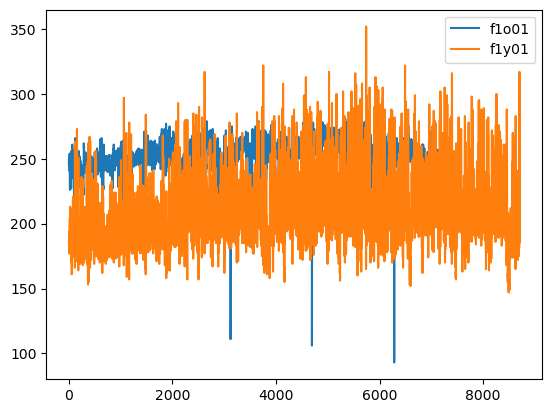

In [7]:
b.iloc[:, [0,10]].plot()

/tmp/ipykernel_15096/2111167856.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RR_intervals[file][(RR_intervals[file]>upper)| ( RR_intervals[file]<lower)]=mean
/tmp/ipykernel_15096/2111167856.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RR_intervals[file][(RR_intervals[file]>upper)| ( RR_intervals[file]<lower)]=mean
/tmp/ipykernel_15096/2111167856.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RR_intervals[file][(RR

<AxesSubplot:>

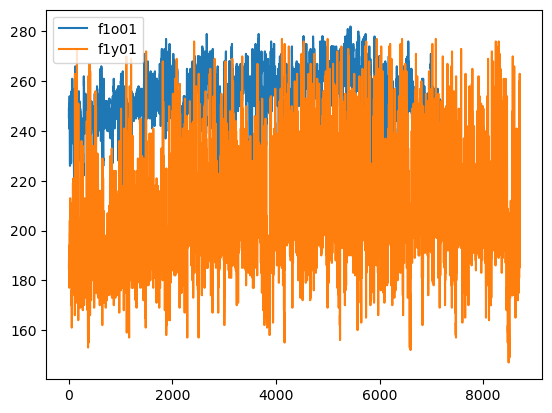

In [8]:
# Cleaning of data by removing b(i) greater than 3*std(b(i))
factor=3
#b.mean(), 
#b.std()

#b


for file in files:
    mean=np.mean(RR_intervals[file])
    std=np.std(RR_intervals[file])
    upper=mean+factor*std
    lower=mean-factor*std
    RR_intervals[file][(RR_intervals[file]>upper)| ( RR_intervals[file]<lower)]=mean

b.iloc[:, [0,10]].plot()

In [9]:
# Compute the cumulative sum of rr intervals ( b(i) intervals in the paper)
B=pd.DataFrame(np.cumsum(RR_intervals, axis=0))

#B_df=[]
#for file in files:
#    B_df.append(pd.DataFrame({file:np.cumsum(RR_intervals[file])}))
#B=pd.concat(B_df, axis=1, ignore_index=True)
#B.columns=files

In [11]:
B.describe() # columns names are correct


<AxesSubplot:>

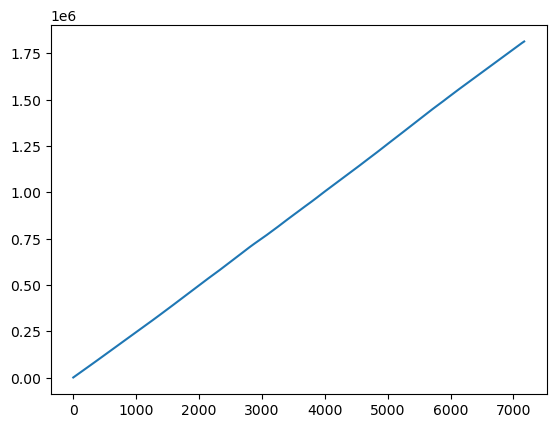

In [10]:
B.iloc[:,0].plot() # we expect a straight line

In [11]:
# library to detrend, could be done with scipy as well, but the library does the job already
from obspy.signal import detrend

In [12]:
# not normalized version
#S=[2**i for i in range(3, 13)]
#poly_order=3 # hyperparameter to change
#list_Delta_B=[]
#list_Delta_B_df=pd.DataFrame(columns=[str(s) for s in S])
#print('S to be used',S)
#f_log=open('log_s.txt', 'w')
#for s in S:
#    B_copied=B.copy()
#    print(s, file=f_log)
#    Delta_B_s=[]#np.array(()) #empty array to store delta s B of all patients, computed with same s
#    for file in files:
#        B_patient=B_copied[file][B_copied[file].notna()].values
#
#        n_segment=int(np.floor(B_patient.size/(2*s)))
#        print(file, ' n_seg', n_segment,  file=f_log)
#        if n_segment!= 0: #avoid useless computing power
#            for segment in range(n_segment):
#                detrend.polynomial(B_patient[segment*2*s: (segment+1)*2*s], order=poly_order, plot=False) # for each sliding segment, detrend
#
#            # the whole B but now detrended
#            detrended=B_patient[0:2*s*n_segment].copy() #only those that are possible to detrend (have at least the 2s space/segment)
#            Delta_s_B_file=np.array([detrended[i+s]-detrended[i] for i in range(2*s*n_segment) if i+s< len(detrended)])
#            Delta_B_s.append(Delta_s_B_file)
#    list_Delta_B.append(np.concatenate(Delta_B_s))
##list_Delta_B_df[str(s)]=np.concatenate(list_Delta_B)
#
#
#
#f_log.close()




S to be used [8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]


In [13]:
S=[2**i for i in range(3, 12)]
poly_order=3 # hyperparameter to change
list_Delta_B=[]
list_Delta_B_df=pd.DataFrame(columns=[str(s) for s in S])
print('S to be used',S)
f_log=open('log_s.txt', 'w')
for s in S:
    B_copied=B.copy()
    print(s, file=f_log)
    Delta_B_s=[]#np.array(()) #empty array to store delta s B of all patients, computed with same s
    for file in files:
        B_patient=B_copied[file][B_copied[file].notna()].values

        n_segment=int(np.floor(B_patient.size/(2*s)))
        print(file, ' n_seg', n_segment,  file=f_log)
        if n_segment!= 0: #avoid useless computing power
            for segment in range(n_segment):
                detrend.polynomial(B_patient[segment*2*s: (segment+1)*2*s], order=poly_order, plot=False) # for each sliding segment, detrend

            # the whole B but now detrended
            detrended=B_patient[0:2*s*n_segment].copy() #only those that are possible to detrend (have at least the 2s space/segment)
            Delta_s_B_file=np.array([detrended[i+s]-detrended[i] for i in range(2*s*n_segment) if i+s< len(detrended)])
            Delta_B_s.append(Delta_s_B_file/np.std(Delta_s_B_file)) #since the std of very patient i svery different from each other we need to normalize the increments and join them togheter
    list_Delta_B.append(np.concatenate(Delta_B_s))



f_log.close()



S to be used [8, 16, 32, 64, 128, 256, 512, 1024, 2048]


In [14]:
[ (S[i], list_Delta_B[i].shape) for i in range(len(list_Delta_B))]

[(8, (221200,)),
 (16, (220640,)),
 (32, (219456,)),
 (64, (217472,)),
 (128, (213760,)),
 (256, (205312,)),
 (512, (189440,)),
 (1024, (159744,)),
 (2048, (86016,))]

In [15]:
len(list_Delta_B), type(list_Delta_B[0])

(9, numpy.ndarray)

In [16]:
def gaus(x, mu, sigma, A):
    return A/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x - mu)**2 / (2*sigma**2))

In [17]:
import scipy

In [18]:
from scipy.integrate import quad

1.000000018208125
1.0000000831714404
1.0000002787219295
1.0000007235989556
1.00000402080924
1.0000108854036511
1.000039682575138
1.000540845360557
1.0171443603895967


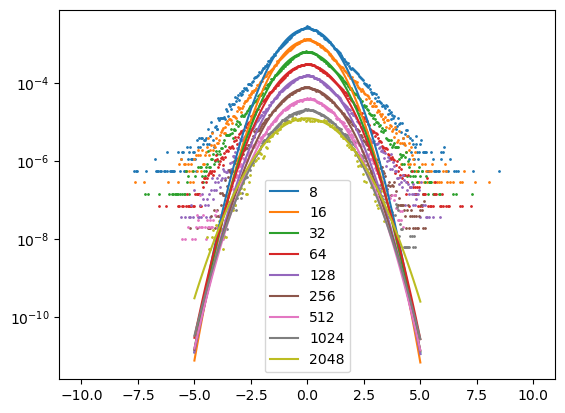

In [19]:
from scipy.optimize import curve_fit

for i,d in enumerate(list_Delta_B):
    print(np.std(d))
    counts, edges=np.histogram(d, bins=int(np.sqrt(d.size)), range=(-10, 10))
    bin_cen=(edges[1:]+edges[:-1])/2
        
    popt, pcov = curve_fit(gaus , bin_cen, counts/(S[i]*len(d)), p0=[1,1,1])
    
    x = np.linspace(-5, 5, 100)
    plt.plot(x, gaus(x, *popt), label=str(S[i]))
    
    plt.scatter(bin_cen, counts/(S[i]*len(d)), s=1)
    plt.yscale('log')
plt.legend()
plt.show()

In [21]:
#from scipy.stats import norm
#
#
#Delta_s_B=[detrended[i+s]-detrended[i] for i in range(2*s*(n_seg-1))]
#counts,w=np.histogram(Delta_s_B/np.std(Delta_s_B), bins=int(np.sqrt(len(Delta_s_B))))


In [33]:
from numpy import trapz
from scipy.integrate import quad

In [35]:
def castaing_integral(x, lambd):
    def little_cast(sigma, lambd, x):
        return 1/(2*np.pi*lambd*sigma**2)*np.exp(-(x**2/sigma**2 + np.log(sigma)**2/lambd**2) / 2)
    result = quad(little_cast, 0, np.inf, args=(lambd, x))
    return result[0]
# scipy_integrate accepts only scalar functions, we can vectorize it this way
Castaing_integral = np.vectorize(castaing_integral)

def C_log10(x, lambd): 
    c = Castaing_integral(x, lambd) 
    return np.log10(c / np.sum(c)) 

0.9999948952473191
0.9999154572540819
0.9994153306513769
0.9978446679155107
0.9946051280448668
0.989424121108394


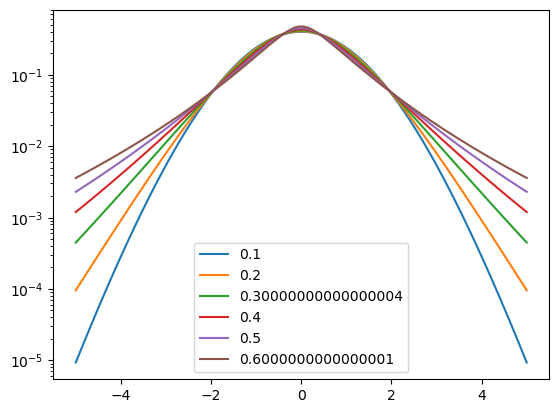

In [46]:
possible_l=[0.1*i for i in range(1,7)]
x=np.linspace(-5,5,100)
for l in possible_l:
    y=Castaing_integral(x, l)
    print(np.trapz(y, x))
    plt.plot(x, y, label=str(l))
plt.yscale('log')
plt.legend()
plt.show()

In [70]:
#from scipy.stats import norm
#
#
##Delta_s_B=[detrended[i+s]-detrended[i] for i in range(2*s*(n_seg-1))]
#
#
#counts,w=np.histogram(Delta_s_B/np.std(Delta_s_B), bins=int(np.sqrt(len(Delta_s_B))))
#
#mu,std=norm.fit(Delta_s_B/np.std(Delta_s_B))
#
#len(Delta_s_B)
#plt.hist(Delta_s_B/np.std(Delta_s_B),bins=int(np.sqrt(len(Delta_s_B))), density=True, log='y')
#xmin, xmax = plt.xlim()
#x = np.linspace(xmin, xmax, 100)
#p = norm.pdf(x, mu, std)
#plt.plot(x, p, 'k', linewidth=2)
#plt.ylim(5e-3, 1)
#plt.show()



Area before norm 9412.765957446809
SONO UGUALI? 221200 221200
Area after norm 0.9999999999999999
1
0.5325145293437563 0.4


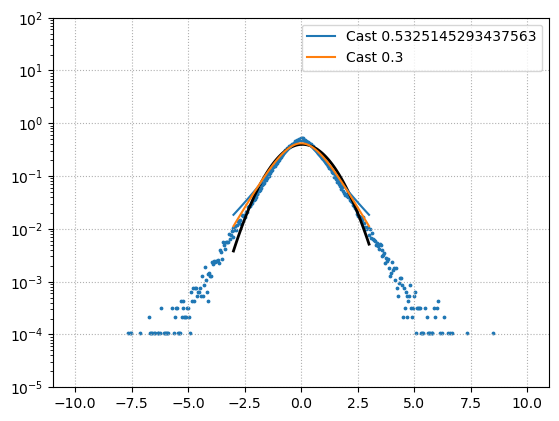

In [99]:
from scipy.stats import norm

d = list_Delta_B[0]
counts, edges=np.histogram(d, bins=int(np.sqrt(d.size)), range=(-10, 10))
bin_cen=(edges[1:]+edges[:-1])/2
print('Area before norm',np.trapz(counts, bin_cen))
#plt.scatter(bin_cen, counts, s=3)

print('SONO UGUALI?',len(d), np.sum(counts))
counts=counts/np.trapz(counts, bin_cen)

print('Area after norm',np.trapz(counts, bin_cen))
plt.scatter(bin_cen, counts, s=3)

mu, std=norm.fit(counts, fscale=1) # to imporove to properly fit data
print(std)
x=np.linspace(-3, 3, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

popt, pcov = curve_fit(Castaing_integral, bin_cen, counts, p0=[np.sqrt(0.16)], bounds=(-3,3))
#
plt.plot(x, Castaing_integral(x, *popt), label='Cast '+str(*popt))
print(*popt, np.sqrt(0.16))

#for i in range(1,20):
plt.plot(x, Castaing_integral(x, 0.3), label='Cast '+str(0.3))


plt.legend()
plt.yscale('log')
plt.ylim(10e-6, 10e1)
plt.grid(linestyle='dotted')
#plt.xlim(-1,1)
#plt.ylim(10e-2, 10e0)
plt.show()

1.000000018208125


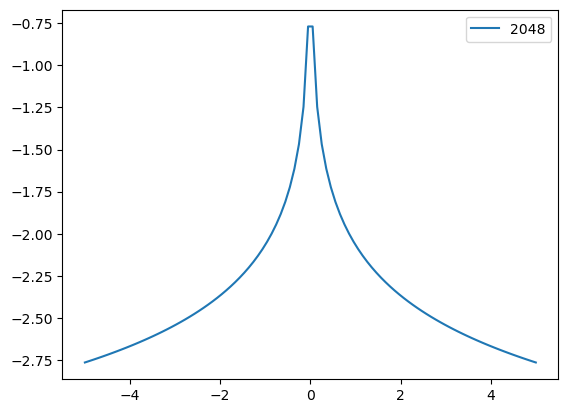

In [24]:

d = list_Delta_B[0]
print(np.std(d))
counts, edges=np.histogram(d, bins=int(np.sqrt(d.size)), range=(-10, 10))
bin_cen=(edges[1:]+edges[:-1])/2

popt, pcov = curve_fit(C_log10 , bin_cen, counts/(8*len(d)), p0=[1])

x = np.linspace(-5, 5, 100)
plt.plot(x, C_log10(x, *popt), label=str(S[i]))

#plt.scatter(bin_cen, counts/(8*len(d)), s=1)
#plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
from scipy.stats import norm


Delta_s_B=[detrended[i+s]-detrended[i] for i in range(2*s*(n_seg-1))]


counts,w=np.histogram(Delta_s_B/np.std(Delta_s_B), bins=int(np.sqrt(len(Delta_s_B))))

mu,std=norm.fit(Delta_s_B/np.std(Delta_s_B))

In [ ]:
len(Delta_s_B)
plt.hist(Delta_s_B/np.std(Delta_s_B),bins=int(np.sqrt(len(Delta_s_B))), density=True, log='y')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.ylim(5e-3, 1)
plt.show()

In [ ]:
#B_copied=B.iloc[:, 0].copy()
#to_detrend=B_copied[B_copied.notna()].values
#detrend.polynomial(to_detrend, order=3, plot=False,)
#plt.hist(to_detrend)

In [ ]:
#plt.hist(Delta_B, bins=int(np.sqrt(len(Delta_B))), density=True, log='y')
#plt.show()

In [ ]:
somma=B(RR_intervals[files[0]], 10)
plt.plot(somma)
#plt.plot(RR_intervals.iloc[:,0])
plt.show()
plt.plot(RR_intervals.iloc[:,0])
plt.axhline(np.mean(RR_intervals.iloc[:, 0])-4*np.std(RR_intervals.iloc[:,0]), 0, 1000)
plt.axhline(np.mean(RR_intervals.iloc[:, 0])+4*np.std(RR_intervals.iloc[:,0]), 0, 1000)

In [ ]:
ann=wfdb.rdann(path+'f2y10', 'ecg')

In [ ]:
plt.plot(sig)
plt.xlim(0,10000)

In [ ]:
rr

In [ ]:

RR_intervals.hist()

In [ ]:
RR_intervals[files[-1]].hist()

In [ ]:
ECG_sig[files[0]].plot(xlim=(0,400))

In [ ]:
ECG_sig.to_hdf('ECG_sig.hdf', key='ECG_sig')
ECG_sig.describe()

In [ ]:
rr_dfs=[]
## Compute R peaks and RR sample distances
for file in files:
    xqrs = processing.XQRS(sig=ECG_sig[file], fs=250)
    xqrs.detect(verbose=False)
    rr=processing.calc_rr(xqrs.qrs_inds,fs=250)
    rr_dfs.append(pd.DataFrame({file: rr}))

    #rr=processing.calc_rr(xqrs.qrs_inds,fs=fields['fs'])
RR_intervals=pd.concat(rr_dfs, ignore_index=True, axis=1)
RR_intervals.columns=files


In [ ]:
ECG_sig.iloc[:,0]

In [ ]:
xqrs = processing.XQRS(sig=ECG_sig.iloc[files[0]], fs=250)
xqrs.detect(verbose=True)
print(xqrs.samples)
rr=processing.calc_rr(xqrs.qrs_inds,fs=250)
print(rr)
#rr_dfs.append(pd.DataFrame({file: rr}))

In [ ]:
rr_dfs[0]

In [ ]:
RR_intervals.to_hdf('RR_intervals.hdf', key='RR_intervals')
RR_intervals.describe()

In [ ]:
len(sig_list

In [ ]:
print(np.shape(sig))

In [ ]:
plt.plot(output[0][:,0], label='breath signal')
plt.plot(output[0][:,1], label='ecg signal')
plt.xlim(0,800)
plt.legend()
plt.show()

In [ ]:
sig, fields = wfdb.rdsamp('physionet.org/files/fantasia/1.0.0/f1o01', channels=[1])
print(sig[:,0])
xqrs = processing.XQRS(sig=sig[:,0], fs=fields['fs'])
xqrs.detect()

In [ ]:
xqrs.qrs_inds

In [ ]:
output[0][:,1]

In [ ]:
#%matplotlib widget
plt.plot(output[0][:,1], label='ecg signal')
plt.scatter(xqrs.qrs_inds, output[0][:,1][xqrs.qrs_inds], color='r')
#plt.xlim(0, 1200)

In [ ]:
wfdb.plot_items(signal=sig, ann_samp=[xqrs.qrs_inds])
#plt.xlim(0,400)
#plt.show()

In [ ]:
ann_ref = wfdb.rdann('physionet.org/files/fantasia/1.0.0/f1o01', 'ecg')

In [ ]:
wfdb.plot_items(signal=sig, ann_samp=[ann_ref.sample])


In [ ]:
comparitor = processing.compare_annotations(ann_ref.sample[1:],
                                                xqrs.qrs_inds,
                                                int(0.01 * fields['fs']),
                                                sig[:,0])
comparitor.print_summary()
comparitor.plot()

In [ ]:
rr=processing.calc_rr(xqrs.qrs_inds,fs=fields['fs'])

In [ ]:
rr

In [ ]:
rr_file=processing.ann2rr('physionet.org/files/fantasia/1.0.0/f1o01', 'ecg')
rr_file

In [ ]:
rr_file.shape, rr.shape

In [ ]:
plt.hist(rr/250, bins=int(np.sqrt(len(rr))), label='ns', density=True)
plt.hist(rr_file/250, bins=int(np.sqrt(len(rr))), label='file', density=True, alpha=0.5)
plt.legend()
#plt.xlim(0.8, 1.2)
plt.show()

In [ ]:
np.mean(rr), np.std(rr)

In [ ]:
np.mean(rr_file), np.std(rr_file)